<a href="https://colab.research.google.com/github/ljn1999/APS360-Applied-Fundamentals-of-Machine-Learning/blob/master/Lab2/Lab_2_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

**Deadline**: January 30, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: 

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

0it [00:00, ?it/s]

170500096it [00:06, 28231206.40it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

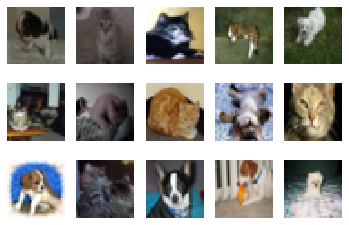

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print("number of training examples in training set:", len(train_loader.dataset))
print("number of training examples in validation set:", len(val_loader.dataset))
print("number of training examples in testing set:", len(test_loader.dataset))

number of training examples in training set: 50000
number of training examples in validation set: 50000
number of training examples in testing set: 10000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
# Because we need to set aside a separate data set to track validation accuracy
# in the training curve, and also make decisions about hyperparameters using the
# validation set.
# if we use training set to judge the performance, we will get overfit, and can
# not make good predictions.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)
print("----------------")
for param in large_net.parameters():
    print(param.shape)

# the number of parameters in small-net is 5*3*3*3+5+1*245+1 = 386,
# and the number of parameters in large-net is 5*3*5*5+5+10*5*5*5+10+32*250+32+1*32+1 = 9705.

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
----------------
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        # print(model_path)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
# batch_size = 64, learning_rate = 0.01, num_epochs = 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
smallNet = SmallNet()
train_net(smallNet,num_epochs=5)
# the current model with 4 checkpoints are saved to the file, in detail,
# model_small_bs64_lr0.01_epoch0: checkpoint at epoch 0
# model_small_bs64_lr0.01_epoch1: checkpoint at epoch 1
# model_small_bs64_lr0.01_epoch2: checkpoint at epoch 2
# model_small_bs64_lr0.01_epoch3: checkpoint at epoch 3
# model_small_bs64_lr0.01_epoch4: checkpoint at epoch 4
# files with error and loss are also saved
# model_small_bs64_lr0.01_epoch4_train_err.csv: training error
# model_small_bs64_lr0.01_epoch4_train_loss.csv: training loss
# model_small_bs64_lr0.01_epoch4_val_err.csv: validation error
# model_small_bs64_lr0.01_epoch4_val_loss.csv: validation loss

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.419625, Train loss: 0.6728679819107055 |Validation err: 0.3715, Validation loss: 0.6522124744951725
Epoch 2: Train err: 0.365, Train loss: 0.6440454392433167 |Validation err: 0.369, Validation loss: 0.6567964870482683
Epoch 3: Train err: 0.3455, Train loss: 0.629099856376648 |Validation err: 0.349, Validation loss: 0.6225278694182634
Epoch 4: Train err: 0.3375, Train loss: 0.6156412010192871 |Validation err: 0.374, Validation loss: 0.6325009446591139
Epoch 5: Train err: 0.332875, Train loss: 0.6083977606296539 |Validation err: 0.3365, Validation loss: 0.6178372092545033
Finished Training
Total time elapsed: 15.75 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
train_net(small_net)
train_net(large_net)
# small_net is faster, because it has fewer parameters than large_net, so it
# takes less time to do the training

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.419625, Train loss: 0.6738961606025696 |Validation err: 0.36, Validation loss: 0.6511919926851988
Epoch 2: Train err: 0.357625, Train loss: 0.636897319316864 |Validation err: 0.3715, Validation loss: 0.650411993265152
Epoch 3: Train err: 0.345125, Train loss: 0.6208259797096253 |Validation err: 0.341, Validation loss: 0.6164770610630512
Epoch 4: Train err: 0.330375, Train loss: 0.6049596142768859 |Validation err: 0.3335, Validation loss: 0.6117078065872192
Epoch 5: Train err: 0.31875, Train loss: 0.595714729309082 |Validation err: 0.329, Validation loss: 0.6070070825517178
Epoch 6: Train err: 0.307875, Train loss: 0.5873187351226806 |Validation err: 0.3235, Validation loss: 0.605830155313015
Epoch 7: Train err: 0.3125, Train loss: 0.5843797640800477 |Validation err: 0.3245, Validation loss: 0.5953542180359364
Epoch 8: Train err: 0.30325, Train loss: 0.5767098603248596 |Validation err: 0.32

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

training curve for small network:


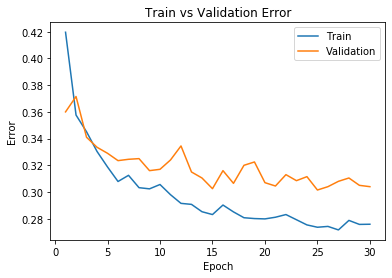

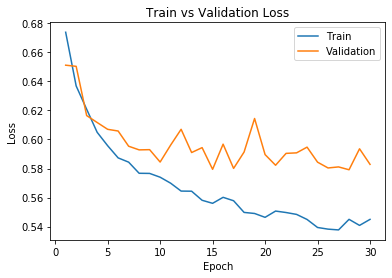

training curve for large network:


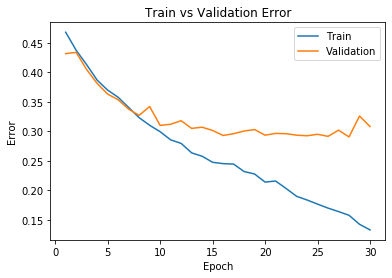

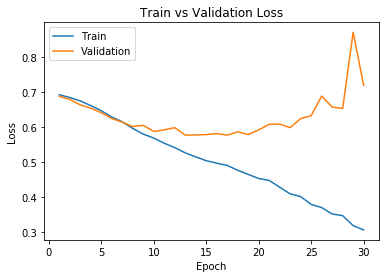

In [ ]:
print("training curve for small network:")
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_small)
print("training curve for large network:")
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
# for small_net, the model shows underfitting at the beginning, the error and 
# loss both goes down as the epoch increases for both training and validation,
# but for large_net, the model shows underfitting at the beginning, the training 
# error and loss keep going down as the epoch increases, 
# but for validation, error stays around the same eventually, and the loss even
# increases, which is a sign of overfitting.
# the small net gets a lower final validation error and loss.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

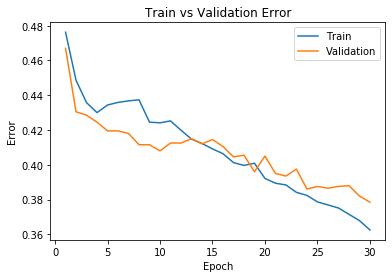

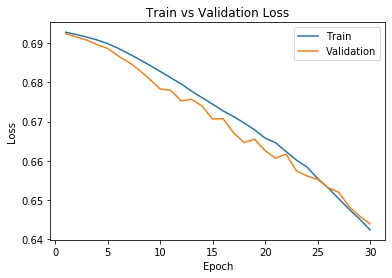

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large)

# the model takes around the same time to train.
# lowing the learning rate makes the model get higher error and higher loss in
# training data. For validation, the error is higher, but the loss shows 
# overfitting is avoided. 0.001 is too slow in this case.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

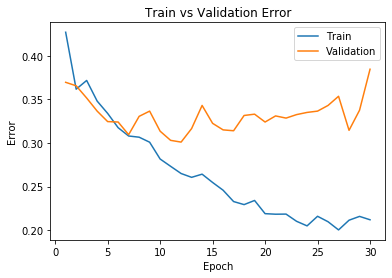

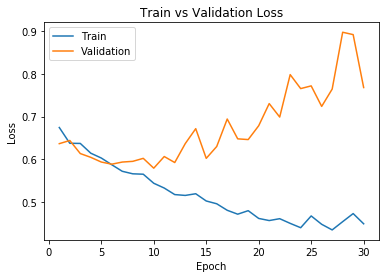

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large)

# the model takes around the same time to train.
# increasing the learning rate makes the model get higher error and higher loss in
# training and validation data, also, the error and loss increase in the second 
# half of the 30 iterations, which is a sign of overfitting. 0.1 is too fast
# in this case.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

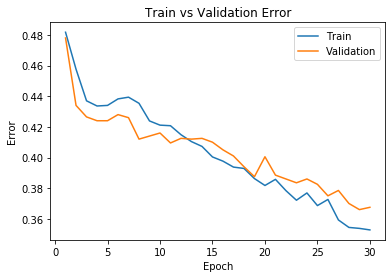

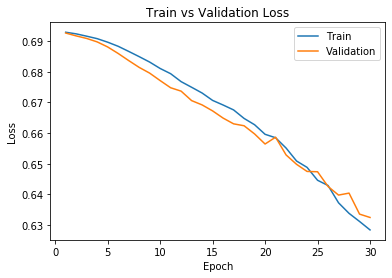

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)
model_path_large = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

# the model takes less time to train, because the batch_size increases, so inside
# 1 epoch, the times of iteration is smaller, which will take less time.
# increasing the batch size makes the model get higher error and higher loss in
# training data. In validation, the error and loss are around the same, but the 
# new loss shows no sign of overfitting.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

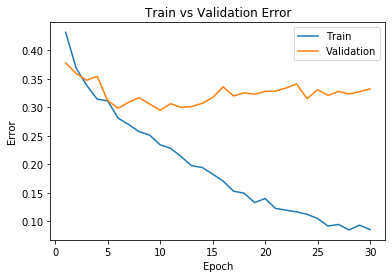

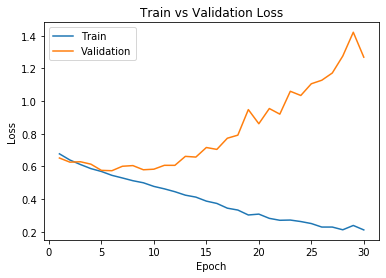

In [ ]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)
model_path_large = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

# the model takes more time to train, because the batch_size decreases, so inside
# 1 epoch, the times of iteration is larger, which will take more time.
# decreasing the batch size makes the model get lower error and lower loss in
# training data. But in validation, the error and loss both show sign of 
# overfitting and the loss get very large.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
# I choose the set of parameter as: (network = large_net, batch_size = 128, 
# learning_rate = 0.01, epoch = 30)
# because through trials, large net works better than small net;
# from part3, 0.01 is a good learning rate; and when batch_size is small,
# the model would get overfitting, when batch_size increases a bit, the 
# peformance is better and shows no sign of overfitting.
# 30 is a good number of epoch, when it is too small, the model gets underfitting,
# when it is too large, the model gets overfitting.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454375, Train loss: 0.6920222535965934 |Validation err: 0.426, Validation loss: 0.6897580400109291
Epoch 2: Train err: 0.44475, Train loss: 0.6877933882531666 |Validation err: 0.4115, Validation loss: 0.6820726208388805
Epoch 3: Train err: 0.422, Train loss: 0.6812239989401803 |Validation err: 0.412, Validation loss: 0.6738845333456993
Epoch 4: Train err: 0.41025, Train loss: 0.6737808935225956 |Validation err: 0.4075, Validation loss: 0.6660195551812649
Epoch 5: Train err: 0.397, Train loss: 0.6661106366959829 |Validation err: 0.401, Validation loss: 0.6589444242417812
Epoch 6: Train err: 0.3765, Train loss: 0.6566641018504188 |Validation err: 0.389, Validation loss: 0.6511358879506588
Epoch 7: Train err: 0.374875, Train loss: 0.648662491450234 |Validation err: 0.3755, Validation loss: 0.6394486390054226
Epoch 8: Train err: 0.359125, Train loss: 0.636394875390189 |Validation err: 0.3685, 

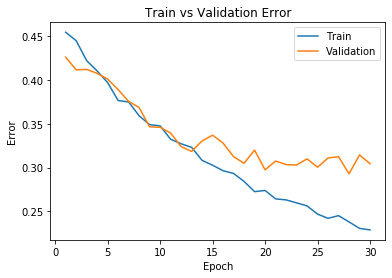

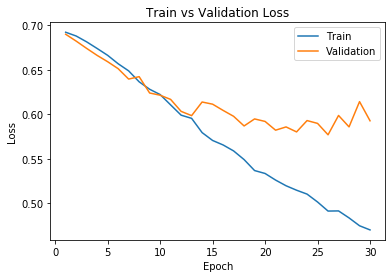

In [ ]:
large_net = LargeNet()
train_net(large_net, 128, 0.01, 30)
model_path_large = get_model_name("large", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [ ]:
# I choose the set of parameter as: (network = large_net, batch_size = 128, 
# learning_rate = 0.008, epoch = 25)
# because in part(b)'s training, in epoch 21~23, the error and loss are the lowest,
# and since I decreased the learning_rate a little bit, the model would probably
# fits best in epoch slightly larger than 21~23
# so I choose epoch = 22 to get a better model.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.486375, Train loss: 0.6933932985578265 |Validation err: 0.4285, Validation loss: 0.6896525919437408
Epoch 2: Train err: 0.4515, Train loss: 0.6887564053611149 |Validation err: 0.421, Validation loss: 0.6837402358651161
Epoch 3: Train err: 0.44225, Train loss: 0.6838553273488605 |Validation err: 0.4135, Validation loss: 0.6771005876362324
Epoch 4: Train err: 0.42425, Train loss: 0.6778600840341478 |Validation err: 0.4085, Validation loss: 0.6689112894237041
Epoch 5: Train err: 0.40625, Train loss: 0.6704813677167135 |Validation err: 0.403, Validation loss: 0.6618930883705616
Epoch 6: Train err: 0.382125, Train loss: 0.6598792927605766 |Validation err: 0.3825, Validation loss: 0.6493760272860527
Epoch 7: Train err: 0.378125, Train loss: 0.6551205686160496 |Validation err: 0.3735, Validation loss: 0.642575092613697
Epoch 8: Train err: 0.370375, Train loss: 0.6465683342918517 |Validation err: 

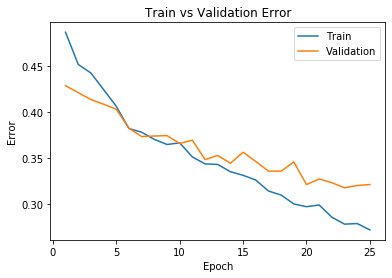

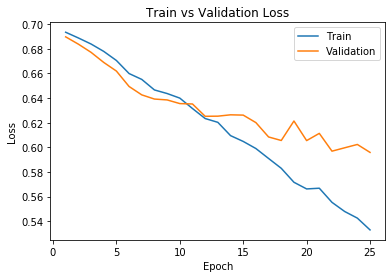

In [ ]:
large_net = LargeNet()
train_net(large_net, 128, 0.008, 25)
model_path_large = get_model_name("large", batch_size=128, learning_rate=0.008, epoch=24)
plot_training_curve(model_path_large)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
train_net(net, 128, 0.008, 25)
model_path = get_model_name("large", batch_size=128, learning_rate=0.008, epoch=24)
state = torch.load(model_path)
net.load_state_dict(state)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.467375, Train loss: 0.6916268382753644 |Validation err: 0.421, Validation loss: 0.6881233491003513
Epoch 2: Train err: 0.444875, Train loss: 0.6872358482981485 |Validation err: 0.4165, Validation loss: 0.6829521618783474
Epoch 3: Train err: 0.420375, Train loss: 0.681897621306162 |Validation err: 0.4, Validation loss: 0.6758026517927647
Epoch 4: Train err: 0.41125, Train loss: 0.6737130426225209 |Validation err: 0.3925, Validation loss: 0.6661658883094788
Epoch 5: Train err: 0.398875, Train loss: 0.6664642237481617 |Validation err: 0.384, Validation loss: 0.6586766391992569
Epoch 6: Train err: 0.388875, Train loss: 0.6576429160814437 |Validation err: 0.3835, Validation loss: 0.6505076624453068
Epoch 7: Train err: 0.37875, Train loss: 0.6489696341847616 |Validation err: 0.3665, Validation loss: 0.6402690000832081
Epoch 8: Train err: 0.371375, Train loss: 0.6393176780806648 |Validation err: 

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# the validation error is: 0.299
# the validation loss is: 0.569
# they are both smaller than the result from the default model

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size = 128)

criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print("test classification error and loss:", test_err, test_loss) 

Files already downloaded and verified
Files already downloaded and verified
test classification error and loss: 0.295 0.563060287386179


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# the test classification error is lower than the lowest validation error.
# But in each iterarion, we are training the data in training set, and doing 
# validation on the validation set, the model is gradually becoming a good fit
# for the training dataset and validation set, so the validation error should be
# smaller than the test error.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
# Because the test data are separated from the training and validation data, 
# they are not trained, so they are unbiased and can evaluate how the model 
# actually fit. If we use the test data too much, they will affect the model and
# thus they can not truly indicate the accuracy of the model.

### Part (f) - 5pt

Train a 2-layer ANN similar to what was used in Lab 1 to classific cats and dogs. Try out different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data. How does the ANN model compare to your CNN model?

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.419125, Train loss: 0.6714658264129881 |Validation err: 0.398, Validation loss: 0.6582800522446632
Epoch 2: Train err: 0.379875, Train loss: 0.6492340545805674 |Validation err: 0.388, Validation loss: 0.6514426730573177
Epoch 3: Train err: 0.366375, Train loss: 0.6378536006760975 |Validation err: 0.3815, Validation loss: 0.6482101529836655
Epoch 4: Train err: 0.359625, Train loss: 0.6295622691275582 |Validation err: 0.392, Validation loss: 0.6536959037184715
Epoch 5: Train err: 0.348875, Train loss: 0.6239601411516704 |Validation err: 0.3795, Validation loss: 0.6437500976026058
Epoch 6: Train err: 0.3345, Train loss: 0.6150485721845476 |Validation err: 0.379, Validation loss: 0.6476834453642368
Epoch 7: Train err: 0.331125, Train loss: 0.608729136368585 |Validation err: 0.3795, Validation loss: 0.6448529027402401
Epoch 8: Train err: 0.323625, Train loss: 0.6004973120159574 |Validation err:

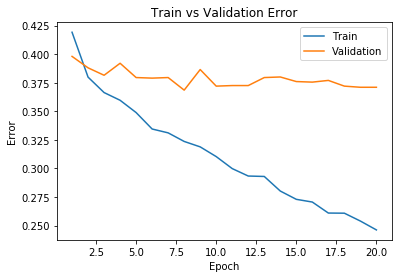

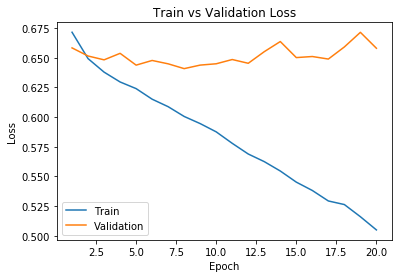

Files already downloaded and verified
Files already downloaded and verified
test classification error and loss: 0.353 0.6489968076348305


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(3*32*32, 30)
        self.layer2 = nn.Linear(30, 1)
        self.name = "ANN"
    def forward(self, img):
        flattened = img.view(-1, 3*32*32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze()

ANN_model = Pigeon()
train_net(ANN_model, 128, 0.005, 20)
model_path_ANN = get_model_name("ANN", batch_size=128, learning_rate=0.005, epoch=19)
plot_training_curve(model_path_ANN)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size = 128)

criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(ANN_model, test_loader, criterion)
print("test classification error and loss:", test_err, test_loss) 

# ANN model has larger error and loss compared with CNN model. Therefore, the
# CNN model fits our problem better.